In [1]:
%load_ext autoreload
%autoreload 2
import os
from Utils.Utils import clean_trials, get_timestamps_from_rec, get_recording_time,plot_probe, assign_DIO_times_to_trials, Trim_TTLs, select_DIO_sync_trial_trace, stitch_bpod_times, select_DIO_channel, find_min_distance_TTL, call_trodesexport, check_single_rec_file, check_timestamps_gaps, get_mouse_name,get_recording_day, find_mat_files_with_same_day, check_gpu_availability
from pathlib import Path
import numpy as np
from spikeinterface.extractors import read_spikegadgets
from spikeinterface.sorters import run_sorter
from spikeinterface.preprocessing import detect_bad_channels
import matplotlib.pyplot as plt
import pandas as pd
import torch
import matplotlib.patches as mpatches
import panel as pn
from tqdm.notebook import tqdm

pn.extension(design="bootstrap", sizing_mode="fixed",throttled=True)

In [2]:
# TODO:
# check gaps mouse 12 20240126
# check gaps mouse 13 20231212
# check timestamps.dat == spikeinterface times

# **Ott lab process single session**
#####  Multi-Neuropixels recording using SpikeGadgets + Bpod

## Imperative folder structure:

- /n_animal
  - /ephys (it has to be called like this)
    - 20240126_184212.rec
    - 20240221_184222.rec
  - /bpod_session (it has to be called like this)
    - 20240126_184212
    - 20240221_184212

# Select file

In [3]:
# folder containing .rec file
path_recording_folder = Path(r"/alzheimer/Roberto/Dariya/12/ephys/20231210_191835.rec")
#path_recording_folder = Path(r"O:\data\12\ephys\20240126_184212.rec")

mouse_n = get_mouse_name(path_recording_folder)
day = get_recording_day(path_recording_folder)
time = get_recording_time(path_recording_folder)
print(f"mouse {mouse_n} recorded on {day} at {time}")

path_recording, rec_file_name = check_single_rec_file(path_recording_folder)

mouse 12 recorded on 20231210 at 19:18:35
Exactly one .rec file found: 20231210_191835.rec


## Extract timestamps from .rec file

In [4]:
%%time
# We adjust timestamps using the timestamps extracted from the .rec file. spikeinterface assumes no gaps (see https://spikeinterface.readthedocs.io/en/latest/modules_gallery/core/plot_6_handle_times.html) and hides all gaps in the recording.

timestamps = get_timestamps_from_rec(path_recording_folder,  path_recording)

Found 3 timestamps.dat files
Read timestamps from /alzheimer/Roberto/Dariya/12/ephys/20231210_191835.rec/20231210_191835.timestamps.dat
CPU times: user 27.1 ms, sys: 135 ms, total: 162 ms
Wall time: 353 ms


/alzheimer/Roberto/Github/spikesorting/Utils/TrodesToPython/readTrodesExtractedDataFile3.py:114: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


## Load recording in spikeinterface

In [5]:
%%time

raw_rec = read_spikegadgets(path_recording)

fs = raw_rec.get_sampling_frequency()

correct_times = timestamps/fs
raw_rec.set_times(correct_times) # set new times, RIGHT NOW IT DOES NOT PROPAGATE TO SORTING OBJECT and AFTER SAVING TO DISK!

print(f"Recording duration in minutes: {raw_rec.get_total_duration()/60}, sampling rate: {fs} Hz")
print(f"Probes present: {raw_rec.get_probes()}")

Recording duration in minutes: 17.64458222222222, sampling rate: 30000.0 Hz
Probes present: [Probe - 384ch - 1shanks, Probe - 384ch - 1shanks]
CPU times: user 126 ms, sys: 93.8 ms, total: 220 ms
Wall time: 220 ms


/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/spikeinterface/core/baserecording.py:429: UserWarning: Setting times with Recording.set_times() is not recommended because times are not always propagated across preprocessingUse this carefully!
  warn(


In [6]:
gaps_start_stop = check_timestamps_gaps(raw_rec, correct_times)

No gaps detected.


# Sync Bpod and Trodes streams

### Export Digital IO channels

In [7]:
%%time
#check if already available, if not extract
call_trodesexport(path_recording_folder, path_recording, "dio")

.DIO folder alread available: 20231210_191835.DIO
CPU times: user 807 µs, sys: 67 µs, total: 874 µs
Wall time: 2.48 ms


In [8]:
DIO_timestamps_start_trial, DIO_samples_start_trial = select_DIO_sync_trial_trace(path_recording_folder, rec_file_name)

20231210_191835.dio_Controller_Din1.dat contains data
1 DIO files with data


## Load bpod mat file behavior

In [9]:
bpod_file = find_mat_files_with_same_day(path_recording_folder.parent.parent / "bpod_session" , path_recording_folder, raw_rec)

.mat file found: /alzheimer/Roberto/Dariya/12/bpod_session/20231210_193822/12_DetectionConfidence_20231210_193822.mat
Bpod file starts outside the Trodes recording!
.mat file found: /alzheimer/Roberto/Dariya/12/bpod_session/20231210_183107/12_DetectionConfidence_20231210_183107.mat
Bpod file starts within the Trodes recording


## Stitch trials and trim as needed

/alzheimer/Roberto/Dariya/12/bpod_session/20231210_183107/12_DetectionConfidence_20231210_183107.mat
Bpod session started at 19:19:28, duration: 16.664601666666666 min, ended at: 19:36:07
number trials: 98
Extracting DetectionConfidence params
CPU times: user 105 ms, sys: 12.5 ms, total: 117 ms
Wall time: 121 ms


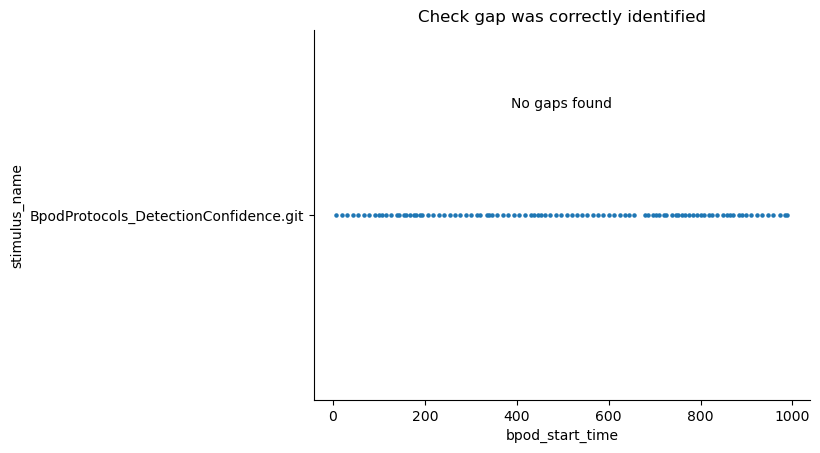

In [10]:
%%time
# currently can deal only with 2 behavior files, no more!
trials =  stitch_bpod_times(bpod_file, day, DIO_timestamps_start_trial)

len DIO:99, len Bpod:98
The most distant pulse in array1 is at index 98 with time 993.3022333333333
This pulse has a minimum distance of 11.916033744812012 to the closest pulse in array2


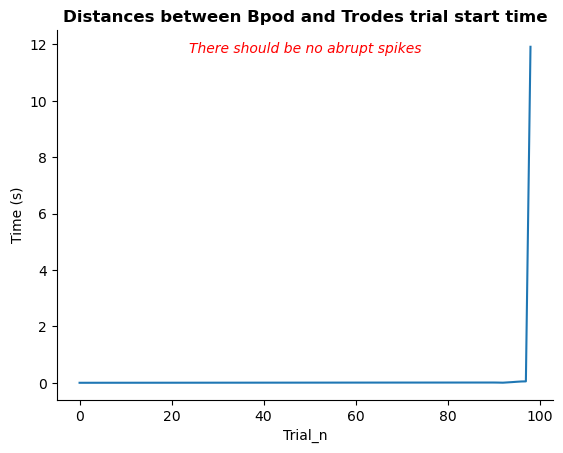

In [11]:
min_distances = find_min_distance_TTL(DIO_timestamps_start_trial,  trials["bpod_start_time"])

In [12]:
# only adapted to case where there is a extra TTL in the DIO at the end of last stimulus block!
DIO_timestamps_start_trial,  DIO_samples_start_trial = Trim_TTLs(trials, DIO_timestamps_start_trial, DIO_samples_start_trial,min_distances)

unequal numbers of trials between bpod and DIO
One extra TTL pulse received on DIO at the end of the session
extra TTL pulse removed


len DIO:98, len Bpod:98
The most distant pulse in array1 is at index 97 with time 981.3359666666668
This pulse has a minimum distance of 0.05023333430290222 to the closest pulse in array2


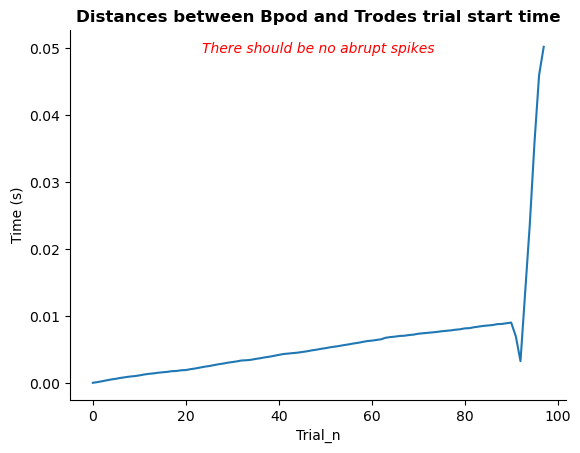

In [13]:
min_distances = find_min_distance_TTL(DIO_timestamps_start_trial,  trials["bpod_start_time"])

CPU times: user 17 ms, sys: 65 µs, total: 17.1 ms
Wall time: 16.1 ms


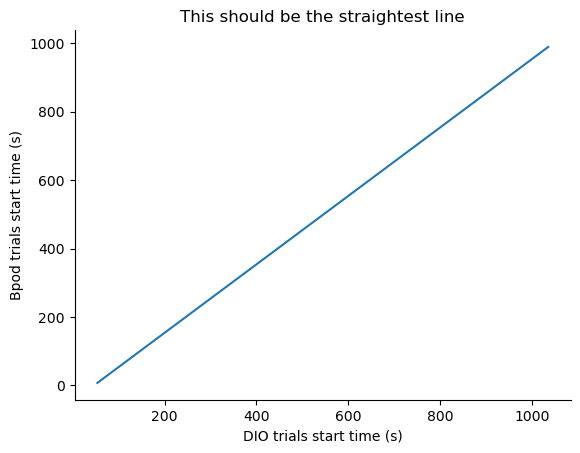

In [14]:
%%time
trials = assign_DIO_times_to_trials(trials, DIO_timestamps_start_trial, DIO_samples_start_trial)

## Final Trial df

In [15]:
%%time
cleaned_trials = clean_trials(trials, raw_rec, gaps_start_stop)

No trials discarded
CPU times: user 5.93 ms, sys: 172 µs, total: 6.1 ms
Wall time: 5.6 ms


In [16]:
cleaned_trials.to_csv(Path(f"{path_recording_folder}/trials.csv"))

In [17]:
pd.read_csv(Path(f"{path_recording_folder}/trials.csv"))

,trial_n,bpod_start_time,bpod_stop_time,stimulus_block,stimulus_name,after_trial_interval,before_trial_interval,beta,bias_version,block_bias,...,reward_start_time,d_i_o_start_sample,d_i_o_start_time,d_i_o_start_sample_zeroed,start_time,duration,stop_time,has_gap,reward_start_time_absolute,stimulus_start_time_absolute
0,0,7.4648,18.4899,0,BpodProtocols_DetectionConfidence.git,1,1,-0.847712,1,0.5,...,NaN,1608245,53.608167,0,0.000000,11.0251,11.025100,False,NaN,NaN
1,1,19.4012,30.4263,0,BpodProtocols_DetectionConfidence.git,1,1,-0.997810,1,0.5,...,NaN,1966340,65.544667,358095,11.936500,11.0251,22.961600,False,NaN,NaN
2,2,31.2975,42.3226,0,BpodProtocols_DetectionConfidence.git,1,1,-1.000000,1,0.5,...,NaN,2323233,77.441100,714988,23.832933,11.0251,34.858033,False,NaN,NaN
3,3,43.1718,54.1969,0,BpodProtocols_DetectionConfidence.git,1,1,1.000000,1,0.5,...,NaN,2679466,89.315533,1071221,35.707367,11.0251,46.732467,False,NaN,NaN
4,4,55.0648,66.0899,0,BpodProtocols_DetectionConfidence.git,1,1,-0.986815,1,0.5,...,NaN,3036260,101.208667,1428015,47.600500,11.0251,58.625600,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,93,945.8506,956.8757,0,BpodProtocols_DetectionConfidence.git,1,1,0.201691,1,0.5,...,NaN,29759415,991.980500,28151170,938.375967,11.0251,949.401067,False,NaN,NaN
94,94,957.7820,971.1213,0,BpodProtocols_DetectionConfidence.git,1,1,-0.920038,1,0.5,...,12.8407,30117051,1003.901700,28508806,950.297167,13.3393,963.636467,False,963.137867,961.152967
95,95,971.9916,983.0167,0,BpodProtocols_DetectionConfidence.git,1,1,-0.189392,1,0.5,...,NaN,30542975,1018.099167,28934730,964.494633,11.0251,975.519733,False,NaN,NaN
96,96,983.9097,987.9648,0,BpodProtocols_DetectionConfidence.git,1,1,-0.378655,1,0.5,...,3.2589,30900212,1030.007067,29291967,976.402533,4.0551,980.457633,False,979.661433,978.626133


# Spike sorting

## Pre-processing

### Detect bad channels

In [18]:
%%time
if os.path.exists(f"{path_recording_folder}/channel_labels.csv"):
    channel_labels = pd.read_csv(f"{path_recording_folder}/channel_labels.csv")
else:
    bad_channel_ids_list = [] 
    channel_labels_list = []
    # detect noisy, dead, and out-of-brain channels
    split_preprocessed_recording = raw_rec.split_by("group")
    for group, sub_rec in tqdm(split_preprocessed_recording.items()):
        bad_channel_ids, channel_labels = detect_bad_channels(sub_rec)
                
        bad_channel_ids_list.append(bad_channel_ids)
        channel_labels_list.extend(channel_labels)
        
    channel_labels = pd.DataFrame([channel_labels_list], index=[ "channel_labels"])
    channel_labels.to_csv(f"{path_recording_folder}/channel_labels.csv", index=False)

bad_channel_ids = channel_labels[~(channel_labels["channel_labels"] == "good")]

CPU times: user 0 ns, sys: 3.56 ms, total: 3.56 ms
Wall time: 5.09 ms


In [19]:
# count bad channels

print(channel_labels["channel_labels"].value_counts())

channel_labels
good    768
Name: count, dtype: int64


### Inspect probes

Column(design=<class 'panel.theme.bootst...)
    [0] EditableRangeSlider(design=<class 'panel.theme.bootst..., end=3920.0, name='y_lim', step=10, value=(3120.0, 3720.0), width=300)
    [1] Matplotlib(Figure, design=<class 'panel.theme.bootst...)
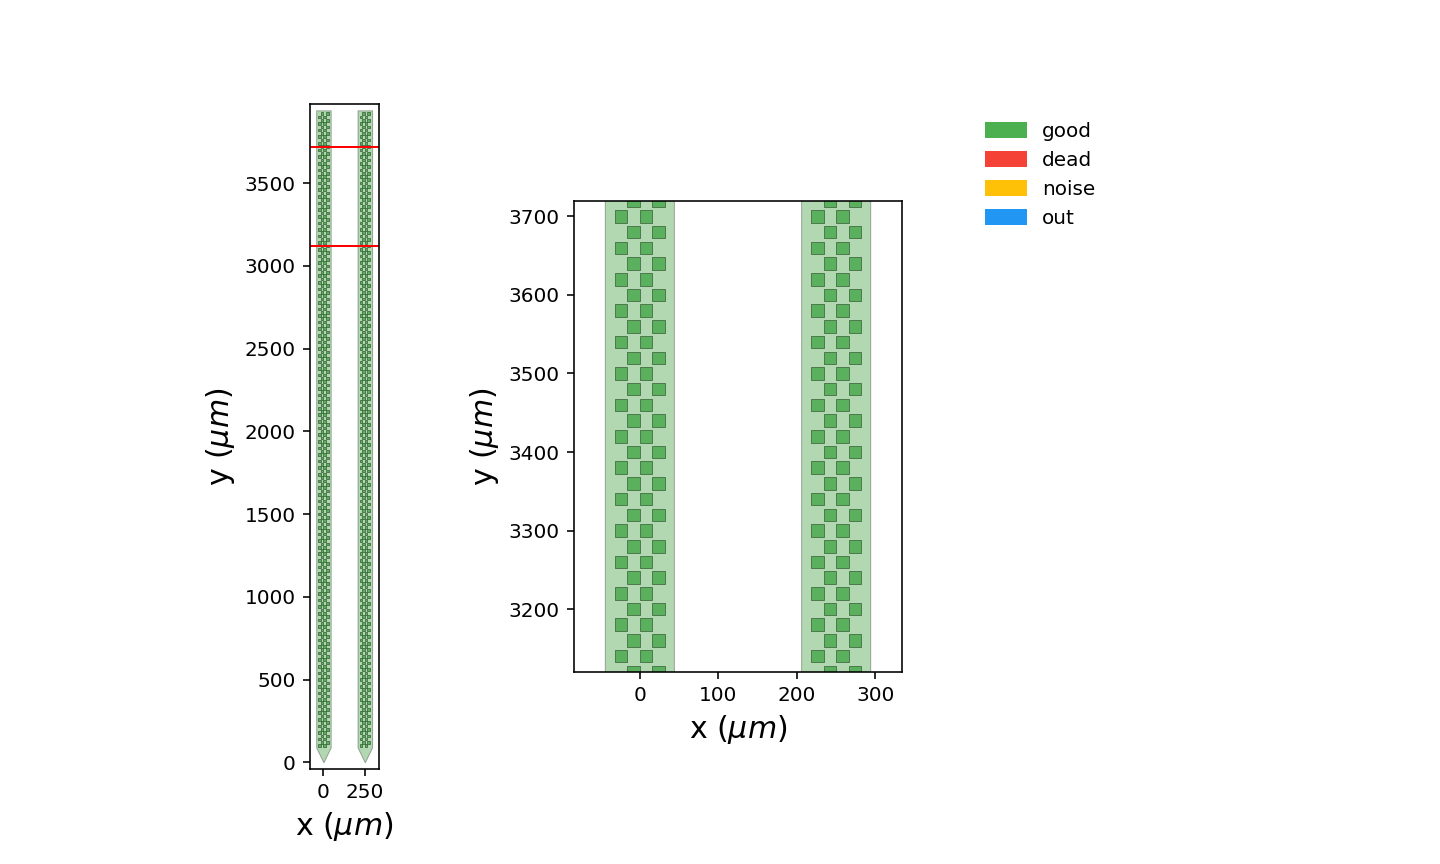

In [20]:
plot_probe(raw_rec, channel_labels["channel_labels"].values)

In [21]:
# remove bad channels
raw_rec = raw_rec.remove_channels(bad_channel_ids)
print("bad channels removed")

bad channels removed


## Sorting

In [ ]:
%%time

check_gpu_availability()

torch.cuda.empty_cache()

split_preprocessed_recording = raw_rec.split_by("group")
for group, sub_rec in split_preprocessed_recording.items():
    sorting = run_sorter(
        sorter_name="kilosort4",
        recording=sub_rec,
        output_folder=f"{path_recording_folder}/spike_interface_output/probe{group}",
        verbose=True,
        remove_existing_folder=True
        )

GPU available: n = 1


# Post-processing

## Manual curation with Phy

### Add custom metrics in phy

In [189]:
from spikeinterface.core import write_binary_recording
from Utils.Settings import job_kwargs
from Utils.Paths import conda_path
from spikeinterface import create_sorting_analyzer

In [ ]:
%%time
split_preprocessed_recording = raw_rec.split_by("group")

for group, sub_rec in split_preprocessed_recording.items():
    write_binary_recording( sub_rec, file_paths=f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/recording.dat", **job_kwargs)

    params_path = Path(f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/params.py")

    # Read, modify, and write in a single operation
    with open(params_path, 'r') as file:
        lines = file.readlines()
    
    with open(params_path, 'w') as file:
        file.writelines(['dat_path = r\'recording.dat\'\n' if line.startswith('dat_path =') else line for line in lines])

    # compute 'isi_violation', 'presence_ratio' to add to phy
    analyzer = create_sorting_analyzer(sorting, sub_rec, sparse=True, format="memory", **job_kwargs , 
                                           folder=f"{path_recording_folder}/spike_interface_output/probe{group}/sorting_analyzer")

    analyzer.compute({"random_spikes": dict(method="uniform", max_spikes_per_unit=500), 
                  "templates": dict(),
                   "noise_levels":dict(),
                  "quality_metrics": dict(metric_names=['isi_violation', 'presence_ratio'])})
    metrics = analyzer.get_extension('quality_metrics').get_data()
    metrics.index.name="cluster_id"
    metrics.reset_index(inplace=True)
    #create .tsv files in sorter_output folder
    for metric in ['isi_violation', 'presence_ratio']:
        metrics[["cluster_id", metric]].to_csv(f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/cluster_{metric}.tsv", sep="\t", index=False)

    # Use ks labels as default
    kslabels = pd.read_csv(f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/cluster_KSLabel.tsv", sep="\t")
    kslabels.rename(columns={"KSLabel": "group"}, inplace=True)
    kslabels.to_csv(f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/cluster_group.tsv", sep="\t", index=False)

### Open phy

In [239]:
#select_probe
group = 1

In [240]:
sorter_path = f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output"  # Set your path here

! source $conda_path && conda activate phy2 && cd $sorter_path && phy template-gui params.py


12:41:41.279 [W] model:1408           File recording.dat does not exist.
12:41:41.563 [W] model:667            Skipping spike waveforms that do not exist, they will be extracted on the fly from the raw data as needed.
12:41:41.567 [W] traces:462           File /alzheimer/Roberto/Dariya/12/ephys/20231210_191835.rec/spike_interface_output/probe1/sorter_output/recording.dat does not exist.
12:41:41.568 [W] traces:462           File /alzheimer/Roberto/Dariya/12/ephys/20231210_191835.rec/spike_interface_output/probe1/sorter_output/recording.dat does not exist.
12:41:54.043 [W] gui:671              Could not create view TraceView.
[1271537:7:0430/124156.694685:ERROR:command_buffer_proxy_impl.cc(141)] ContextResult::kTransientFailure: Failed to send GpuChannelMsg_CreateCommandBuffer.
[1271538:7:0430/124156.695245:ERROR:command_buffer_proxy_impl.cc(141)] ContextResult::kTransientFailure: Failed to send GpuChannelMsg_CreateCommandBuffer.
12:42:08.631 [I] supervisor:700       Merge clusters 0, 1

# Calculate metrics on selected clusters

In [192]:
from spikeinterface.extractors import read_phy
from spikeinterface import create_sorting_analyzer, load_sorting_analyzer
from spikeinterface.qualitymetrics import compute_quality_metrics, get_quality_metric_list, get_quality_pca_metric_list
from spikeinterface.sorters import read_sorter_folder
from spikeinterface.postprocessing import compute_template_metrics
from spikeinterface.exporters import export_to_phy
from spikeinterface.core import write_binary_recording

In [241]:
sorting = read_phy(f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/")

In [242]:
sorting.unit_ids

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 18

In [ ]:
analyzer = create_sorting_analyzer(sorting, sub_rec, sparse=True, format="binary_folder",  **job_kwargs, 
                                   folder=f"{path_recording_folder}/spike_interface_output/probe{group}/sorting_analyzer") # job params propagate

analyzer.compute({"random_spikes": dict(method="uniform", max_spikes_per_unit=500), 
                  "waveforms":  dict(ms_before=1,ms_after=2.),
                  'spike_amplitudes':dict(),
                 "templates": dict(operators=["average", "std"]),
                 "noise_levels":dict(), 
                 'correlograms':dict() ,
                 'unit_locations':dict(method="monopolar_triangulation"),
                 'template_similarity':dict(),
                 "template_metrics":dict(include_multi_channel_metrics=True),
                 "spike_locations":dict(),
                 "quality_metrics": dict(metric_names=get_quality_metric_list())})

#analyzer.compute("principal_components", **job_kwargs)

metrics = pd.concat([analyzer.get_extension('quality_metrics').get_data(), analyzer.get_extension("template_metrics").get_data()], axis=1)# add template metrics

np.testing.assert_array_equal(analyzer.unit_ids ,  metrics.index)

metrics["probe_n"] = f"probe{group}"
metrics.index.name= "unit_id"
metrics.to_csv(f"{path_recording_folder}/spike_interface_output/probe{group}/metrics")

In [194]:
%%time

# Here we calculate the following metrics: ['num_spikes','firing_rate','presence_ratio','snr','isi_violation','rp_violation','sliding_rp_violation','amplitude_cutoff','amplitude_median','amplitude_cv','synchrony','firing_range','drift','sd_ratio']
 
split_preprocessed_recording = raw_rec.split_by("group")
for group, sub_rec in split_preprocessed_recording.items(): # we do this on single probes, save space!

    print(f"Processing probe{group}")
    
    try:
        sorting = read_phy(f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/") # this will be updated with merges and split
    except:
        print("problem with read_phy, fall on read_sorter_folder")
        sorting = read_sorter_folder(f"{path_recording_folder}/spike_interface_output/probe{group}/") # not including merges and split
    
    analyzer = create_sorting_analyzer(sorting, sub_rec, sparse=True, format="binary_folder",  **job_kwargs, 
                                       folder=f"{path_recording_folder}/spike_interface_output/probe{group}/sorting_analyzer") # job params propagate

    analyzer.compute({"random_spikes": dict(method="uniform", max_spikes_per_unit=500), 
                      "waveforms":  dict(ms_before=1,ms_after=2.),
                      'spike_amplitudes':dict(),
                     "templates": dict(operators=["average", "std"]),
                     "noise_levels":dict(), 
                      'correlograms':dict() ,
                     'unit_locations':dict(method="monopolar_triangulation"),
                     'template_similarity':dict(),
                     "template_metrics":dict(include_multi_channel_metrics=True),
                     "spike_locations":dict(),
                     "quality_metrics": dict(metric_names=get_quality_metric_list())})

    #analyzer.compute("principal_components", **job_kwargs)
    
    metrics = pd.concat([analyzer.get_extension('quality_metrics').get_data(), analyzer.get_extension("template_metrics").get_data()], axis=1)# add template metrics

    np.testing.assert_array_equal(analyzer.unit_ids,  metrics.index)# check ids are updatd after phy curation
    
    metrics["probe_n"] = f"probe{group}"
    metrics.index.name= "unit_id"
    metrics.to_csv(f"{path_recording_folder}/spike_interface_output/probe{group}/metrics")
    
    # TODO order extensions to be checked

Processing probe0


KeyError: 'sample_rate'

In [185]:
#si.get_template_extremum_amplitude(analyzer)

In [186]:
#pd.DataFrame(analyzer.get_channel_locations())

In [187]:
#si.get_template_extremum_channel(analyzer, outputs="index")

In [188]:
#analyzer.get_channel_locations()

No gaps detected.


# Trash

### Export Analog IO channels

In [160]:
%%time
extract_analogIO(path_recording_folder, path_recording)# 55 min too slow


'.analog' folder alread available: 20231212_183552.analog
CPU times: user 553 µs, sys: 109 µs, total: 662 µs
Wall time: 770 µs


### Export timestamps

In [161]:
%%time
#extract_time(path_recording_folder, path_recording) # slower than analogIO somehow!!

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.78 µs


## Load Trodes timestamps

In [174]:
path_analogIO_folder = Path(path_recording_folder,  f"{rec_file_name[:rec_file_name.rfind('.')]}.analog")

In [521]:
from Utils.TrodesToPython.readTrodesExtractedDataFile3 import readTrodesExtractedDataFile, get_Trodes_timestamps
analog_dict = readTrodesExtractedDataFile(Path(path_analogIO_folder, f"{rec_file_name[:rec_file_name.rfind('.')]}.timestamps.dat"))

NameError: name 'path_analogIO_folder' is not defined

In [178]:
analog_dict["data"].shape

(277320457,)

In [179]:
raw_rec.get_total_samples()

277320457

In [640]:
%%time
kilosort_timestamp2 = get_Trodes_timestamps(Path("/alzheimer/Roberto/Dariya/12/ephys/20240126_184212.rec/test/20240126_184212.timestamps.dat"))

CPU times: user 849 µs, sys: 467 ms, total: 468 ms
Wall time: 465 ms


In [643]:
kilosort_timestamp2

array([  2871885,   2871886,   2871887, ..., 227366668, 227366669,
       227366670], dtype=uint32)

In [187]:
analog_dict["data"]["time"]

array([  1279032,   1279033,   1279034, ..., 278599486, 278599487,
       278599488], dtype=uint32)

In [641]:
%%time
kilosort_timestamp = readTrodesExtractedDataFile(Path("/alzheimer/Roberto/Dariya/12/ephys/20240126_184212.rec/test/20240126_184212.timestamps.dat"))

CPU times: user 0 ns, sys: 452 ms, total: 452 ms
Wall time: 449 ms


In [638]:
kilosort_timestamp["data"]["time"]

array([  2871885,   2871886,   2871887, ..., 227366668, 227366669,
       227366670], dtype=uint32)

In [671]:
analog_timestamp = readTrodesExtractedDataFile(Path("/alzheimer/Roberto/Dariya/12/ephys/20240126_184212.rec/test/20240126_184212.timestampsanalog.dat"))

In [608]:
np.unique(np.diff(analog_timestamp["data"]["time"]))

array([   1,    2,    3,  691, 1437, 2094, 2374, 2375, 2390, 2391],
      dtype=uint32)

In [609]:
np.unique(np.diff(kilosort_timestamp["data"]["time"]))

array([   1,    2,    3,  691, 1437, 2094, 2374, 2375, 2390, 2391],
      dtype=uint32)

In [539]:
np.unique(np.diff(raw_rec.get_times()))

array([3.33333328e-05, 3.33333332e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333334e-05, 3.33333335e-05, 3.33333337e-05])

In [601]:
raw_rec.get_times()

array([0.00000000e+00, 3.33333333e-05, 6.66666667e-05, ...,
       7.48217130e+03, 7.48217133e+03, 7.48217137e+03])

In [604]:
(analog_timestamp["data"]["time"]- analog_timestamp["data"]["time"][0]) / 30000.0

array([0.00000000e+00, 3.33333333e-05, 6.66666667e-05, ...,
       7.48315943e+03, 7.48315947e+03, 7.48315950e+03])

In [513]:
analog_timestamp["data"]["time"]

array([  2871885,   2871886,   2871887, ..., 227366668, 227366669,
       227366670], dtype=uint32)

In [655]:
%%time
t=readTrodesExtractedDataFile(Path("/alzheimer/Roberto/Dariya/12/ephys/20231212_183552.rec/20231212_183552.analog/20231212_183552.analog_Headstage_GyroX.dat"))

CPU times: user 3.59 ms, sys: 1.66 s, total: 1.66 s
Wall time: 6.6 s


In [670]:
path_timestamps = find_file("/alzheimer/Roberto/Dariya/12/ephys/20231212_183552.rec/", "timestamps.dat")
path_timestamps

Found 1 timestamps.dat files


['/alzheimer/Roberto/Dariya/12/ephys/20231212_183552.rec/20231212_183552.analog/20231212_183552.timestamps.dat']

In [666]:
path_timestamps

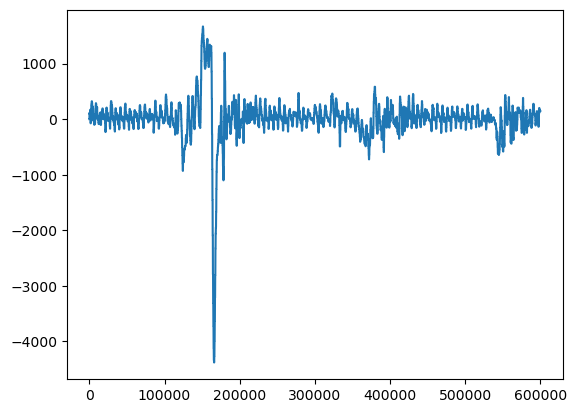

In [657]:
plt.plot(t["data"]["voltage"][:30000*20])

In [38]:
import spikeinterface.full as si

In [103]:
sorting = si.read_sorter_folder(f"/alzheimer/Roberto/Dariya/12/ephys/20240126_184212.rec/spike_interface_output/probe1/")

In [123]:
split_preprocessed_recording = raw_rec.split_by("group")

In [124]:
split_preprocessed_recording[0].get_time_info()

{'sampling_frequency': 30000.0,
 't_start': None,
 'time_vector': array([  10.        ,   10.00003333,   10.00006667, ..., 7493.15943333,
        7493.15946667, 7493.1595    ])}

In [52]:
np.unique(np.diff(sorting.get_times()))

array([3.33333328e-05, 3.33333332e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333334e-05, 3.33333335e-05, 3.33333337e-05])

In [49]:
sorting.register_recording(raw_rec)

In [50]:
np.unique(np.diff(sorting.get_times()))

array([3.33333328e-05, 3.33333332e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333334e-05, 3.33333335e-05, 3.33333337e-05,
       6.66666665e-05, 6.66666666e-05, 6.66666667e-05, 6.66666667e-05,
       6.66666667e-05, 6.66666667e-05, 6.66666667e-05, 6.66666670e-05,
       6.66666674e-05, 9.99999993e-05, 9.99999997e-05, 1.00000000e-04,
       1.00000000e-04, 2.30333333e-02, 4.79000000e-02, 6.98000000e-02,
       7.91333333e-02, 7.91333333e-02, 7.91666667e-02, 7.91666667e-02,
       7.96666667e-02, 7.97000000e-02])

In [95]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
from spikeinterface import aggregate_channels
from probeinterface import generate_tetrode, ProbeGroup
import numpy as np

# Create a toy 384 channel recording with 4 shanks (each shank contain 96 channels)
recording, _ = se.toy_example(duration=[16.00], num_segments=1, num_channels=384)
four_shank_groupings = np.repeat([0, 1, 2, 3], 96)
recording.set_property("group", four_shank_groupings)

print(recording.get_channel_groups())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [96]:
times = recording.get_times()

In [97]:
times

array([0.00000000e+00, 3.33333333e-05, 6.66666667e-05, ...,
       1.59999000e+01, 1.59999333e+01, 1.59999667e+01])

In [98]:
recording.set_times(times+10)

/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/spikeinterface/core/baserecording.py:429: UserWarning: Setting times with Recording.set_times() is not recommended because times are not always propagated across preprocessingUse this carefully!
  warn(


In [99]:
recording.get_times()

array([10.        , 10.00003333, 10.00006667, ..., 25.9999    ,
       25.99993333, 25.99996667])

In [100]:
split_recordings_dict = recording.split_by("group")

In [101]:
 preprocessed_recordings = []

# loop over the recordings contained in the dictionary
 for chan_group_rec in split_recordings_dict.values():

     filtered_recording = spre.bandpass_filter(chan_group_rec)

     referenced_recording = spre.common_reference(filtered_recording)

     preprocessed_recordings.append(referenced_recording)

 # Combine our preprocessed channel groups back together
 combined_preprocessed_recording = aggregate_channels(preprocessed_recordings)

In [ ]:
split_preprocessed_recording =  combined_preprocessed_recording.split_by("group")

sortings = {}
for group, sub_recording in split_preprocessed_recording.items():
    sorting = run_sorter(
        sorter_name='kilosort4',
        recording=sub_recording,
        output_folder=f"folder_KS2_group{group}"
        )
    sortings[group] = sorting

In [131]:
sorting.get_times()

array([0.00000000e+00, 3.33333333e-05, 6.66666667e-05, ...,
       1.59999000e+01, 1.59999333e+01, 1.59999667e+01])

In [130]:
split_preprocessed_recording[0].get_times()

array([10.        , 10.00003333, 10.00006667, ..., 25.9999    ,
       25.99993333, 25.99996667])

## save space

In [41]:
analyzer = load_sorting_analyzer(f"{path_recording_folder}/spike_interface_output/probe0/sorting_analyzer_allchan/")
analyzer

SortingAnalyzer: 768 channels - 278 units - 1 segments - binary_folder - sparse - has recording
Loaded 10 extensions: spike_amplitudes, waveforms, unit_locations, template_similarity, templates, template_metrics, random_spikes, noise_levels, correlograms, quality_metrics

In [42]:
analyzer = load_sorting_analyzer(f"{path_recording_folder}/spike_interface_output/probe0/sorting_analyzer/")
analyzer

SortingAnalyzer: 384 channels - 278 units - 1 segments - binary_folder - sparse - has recording
Loaded 11 extensions: spike_amplitudes, template_similarity, random_spikes, templates, spike_locations, unit_locations, noise_levels, correlograms, waveforms, template_metrics, quality_metrics